# Geyser Watch

## Predicting geyser eruptions at Yellowstone National Park

Yellowstone National Park is famous for geothermal features called Geysers that erupt and shoot boiling hot water up in the air. Visitors rely on National Park Service (NPS) provided predictions to plan their day and witness the eruptions.

However, the NPS provided predictions often have impractical time windows such as ±45 to ±120 minutes. This project focuses on trying to improve prediction times and provide reasonable time windows to aid visitors plan better.

In [1]:
#setup

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

import math

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from datetime import datetime

### Importing Data

The historical data for geyser eruptions was accessed from GeyserTimes.org

In [2]:
df = pd.read_csv('geysertimes_eruptions_complete_2019-09-06.tsv', sep='\t', header=0)
print(df.shape)
df.head()

/home/siddharth/anaconda3/envs/insight/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1130876, 22)


,eruptionID,geyser,eruption_time_epoch,has_seconds,exact,ns,ie,E,A,wc,ini,maj,min,q,duration,entrant,observer,eruption_comment,time_updated,time_entered,associated_primaryID,other_comments
0,580997,King,-2067469500,0,1,0,0,0,0,0,0,0,0,0,12 minutes,Tara,Frank Clark,"Height ~75 feet. Archive document 7332, Corpo...",1367188624,1367188624,580997,NaN
1,580998,King,-2067388500,0,1,0,0,0,0,0,0,0,0,0,NaN,Tara,Frank Clark,"Height ~75 feet. Archive document 7332, Corpo...",1367188867,1367188867,580998,NaN
2,581000,King,-2067211200,0,1,0,0,0,0,0,0,0,0,0,9 minutes,Tara,Frank Clark,"Height ~75 feet. Archive document 7332, Corpo...",1367189475,1367189475,581000,NaN
3,581031,King,-2042489400,0,1,0,0,0,0,0,0,0,0,0,10 minutes,Tara,Frank Clark,Height ~40 feet. Reported by the name \\&quot...,1367191741,1367191741,581031,NaN
4,581033,King,-2042436540,0,1,0,0,0,0,0,0,0,0,0,8 minutes,Tara,Frank Clark,Height ~80 feet. Reported by the name \\&quot...,1367191799,1367191799,581033,NaN


### Pre-processing

In [3]:
# creating a datetime column by converting epoch to datetime
df['datetime'] = pd.to_datetime(df['eruption_time_epoch'],unit='s')

In [4]:
# checking if object is timezone aware
print(df.iloc[0].datetime.tzinfo)

# Checking UTC times
print(df.iloc[0].datetime)

None
1904-06-26 22:55:00


In [5]:
# Converting to Mountain time
df['datetime'] = df['datetime'].dt.tz_localize('utc').dt.tz_convert('US/Mountain')

# Checking Mountain time
print(df.iloc[0].datetime)

1904-06-26 15:55:00-07:00


In [6]:
# adding individual columns for date and time
df['date'] = [d.date() for d in df['datetime']]
df['time'] = [d.time() for d in df['datetime']]

# converting datetime into index
df = df.set_index('datetime')
df.head()

,eruptionID,geyser,eruption_time_epoch,has_seconds,exact,ns,ie,E,A,wc,ini,maj,min,q,duration,entrant,observer,eruption_comment,time_updated,time_entered,associated_primaryID,other_comments,date,time
datetime,,,,,,,,,,,,,,,,,,,,,,,,
1904-06-26 15:55:00-07:00,580997,King,-2067469500,0,1,0,0,0,0,0,0,0,0,0,12 minutes,Tara,Frank Clark,"Height ~75 feet. Archive document 7332, Corpo...",1367188624,1367188624,580997,NaN,1904-06-26,15:55:00
1904-06-27 14:25:00-07:00,580998,King,-2067388500,0,1,0,0,0,0,0,0,0,0,0,NaN,Tara,Frank Clark,"Height ~75 feet. Archive document 7332, Corpo...",1367188867,1367188867,580998,NaN,1904-06-27,14:25:00
1904-06-29 15:40:00-07:00,581000,King,-2067211200,0,1,0,0,0,0,0,0,0,0,0,9 minutes,Tara,Frank Clark,"Height ~75 feet. Archive document 7332, Corpo...",1367189475,1367189475,581000,NaN,1904-06-29,15:40:00
1905-04-11 18:50:00-07:00,581031,King,-2042489400,0,1,0,0,0,0,0,0,0,0,0,10 minutes,Tara,Frank Clark,Height ~40 feet. Reported by the name \\&quot...,1367191741,1367191741,581031,NaN,1905-04-11,18:50:00
1905-04-12 09:31:00-07:00,581033,King,-2042436540,0,1,0,0,0,0,0,0,0,0,0,8 minutes,Tara,Frank Clark,Height ~80 feet. Reported by the name \\&quot...,1367191799,1367191799,581033,NaN,1905-04-12,09:31:00


In [7]:
# Removing all data before the year 2000
print(df.shape)
df = df.loc['2000':]
print(df.shape)

# Best to train model on recent data

(1130876, 24)
(958730, 24)


In [8]:
#Removing records tagged as questionable and dropping the q column
print(df.loc[df['q']==1].shape)
df = df.loc[df['q'] == 0]
print(df.shape)
df.drop('q', axis=1, inplace=True)

(3072, 24)
(955658, 24)


In [9]:
#Removing records tagged as Approximate and dropping the A column
print(df.loc[df['A']==1].shape)
df = df.loc[df['A'] == 0]
print(df.shape)
df.drop('A', axis=1, inplace=True)

(1060, 23)
(954598, 23)


In [10]:
# Removing duplicate entries by only retaining those entries where eruptionID and associated_primaryID are identical

print(df.loc[df['eruptionID'] == df['associated_primaryID']].shape)
df = df.loc[df['eruptionID'] == df['associated_primaryID']]
print(df.shape)

(822119, 22)
(822119, 22)


In [11]:
# Dropping duplicate indexes - indices?

df = df.loc[~df.index.duplicated(keep='first')]
df.shape

# There are 35690 cases where two or more geysers have erupted at exactly the same time down to the minute/seconds.
# This can either be a genuine possibility or recording error
# In the interest of keeping unique datetime index, dropping all duplicates and keeping the first

(786429, 22)

In [12]:
df.columns

Index(['eruptionID', 'geyser', 'eruption_time_epoch', 'has_seconds', 'exact',
       'ns', 'ie', 'E', 'wc', 'ini', 'maj', 'min', 'duration', 'entrant',
       'observer', 'eruption_comment', 'time_updated', 'time_entered',
       'associated_primaryID', 'other_comments', 'date', 'time'],
      dtype='object')

In [13]:
# Dropping columns which will not be used for feature engineering / which don't contain relevant information
cols = ['eruptionID', 'associated_primaryID', 'has_seconds', 'ini', 'entrant', 'observer', 'eruption_comment', 'time_updated', 'time_entered', 'other_comments']
df.drop(cols ,axis=1, inplace=True)

In [14]:
# Adding interval_length column
df['interval_length'] = np.nan
print(df.shape)
df.columns

(786429, 13)


Index(['geyser', 'eruption_time_epoch', 'exact', 'ns', 'ie', 'E', 'wc', 'maj',
       'min', 'duration', 'date', 'time', 'interval_length'],
      dtype='object')

In [15]:
# A look at the dataframe
df.head()

,geyser,eruption_time_epoch,exact,ns,ie,E,wc,maj,min,duration,date,time,interval_length
datetime,,,,,,,,,,,,,
2000-01-01 05:12:00-07:00,Great Fountain,946728720,0,0,0,1,0,0,0,NaN,2000-01-01,05:12:00,NaN
2000-01-01 05:59:00-07:00,Grand,946731540,0,0,0,1,0,0,0,NaN,2000-01-01,05:59:00,NaN
2000-01-01 16:37:00-07:00,Great Fountain,946769820,0,0,0,1,0,0,0,NaN,2000-01-01,16:37:00,NaN
2000-01-01 17:14:00-07:00,Grand,946772040,0,0,0,1,0,0,0,NaN,2000-01-01,17:14:00,NaN
2000-01-02 04:18:00-07:00,Great Fountain,946811880,0,0,0,1,0,0,0,NaN,2000-01-02,04:18:00,NaN


In [16]:
### Populating the interval_length column and prev_maj/prev_min columns

# Creating an empty initial-timestamp dictionary  
geyser_ini_timestamp_dict = dict.fromkeys(df.geyser.unique(),0)

# Populating timstamp dictionary with initial timestamps
for i in df.index:
    geyser = df.get_value(i,'geyser')
    if geyser_ini_timestamp_dict[geyser] == 0:
        geyser_ini_timestamp_dict[geyser] = i
        

# Copying initial timestamp dictionary to working timestamp dictionary
geyser_work_timestamp_dict = geyser_ini_timestamp_dict

# Print and check everything is ok
for ky,vl in geyser_work_timestamp_dict.items():
    print(ky, vl)


/home/siddharth/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


Great Fountain 2000-01-01 05:12:00-07:00
Grand 2000-01-01 05:59:00-07:00
Giantess 2000-01-07 13:27:00-07:00
Giant 2000-01-08 00:00:00-07:00
Fan and Mortar 2000-01-09 13:50:00-07:00
Lakeshore 2000-02-10 15:10:00-07:00
Lone Pine 2000-02-20 10:45:00-07:00
Fountain 2000-04-21 09:41:00-06:00
Steamboat 2000-05-02 06:00:00-06:00
Echinus 2000-05-03 11:30:00-06:00
Daisy 2000-05-14 07:45:39-06:00
Aurum 2000-05-26 11:01:00-06:00
Plume 2000-05-26 11:21:00-06:00
Beehive's Indicator 2000-05-26 11:26:00-06:00
Beehive 2000-05-26 11:50:00-06:00
Boardwalk 2000-05-26 12:54:00-06:00
Rift 2000-05-26 13:25:00-06:00
Riverside 2000-05-26 14:23:00-06:00
Artemisia 2000-05-26 14:30:00-06:00
Grotto Fountain 2000-05-26 15:22:00-06:00
Grotto 2000-05-26 15:25:00-06:00
Flood 2000-05-27 10:09:00-06:00
Botryoidal 2000-05-27 10:16:00-06:00
White Dome 2000-05-27 10:22:00-06:00
Constant 2000-05-27 10:28:00-06:00
A-0 2000-05-27 10:31:00-06:00
Pinto 2000-05-27 10:52:00-06:00
Depression 2000-05-27 12:12:00-06:00
Turban 2000-

In [17]:
# Calculating interval_durations and populating prev_maj/prev_min columns

for i in df.index:
    geyser = df.get_value(i,'geyser')
    prev_timestamp = geyser_work_timestamp_dict[geyser]
    if i == prev_timestamp:
        pass
    else:
        tdelta = i - prev_timestamp
        tdelta = (tdelta.total_seconds() // 60)
        
        df.set_value(i, 'interval_length', tdelta)
        
        geyser_work_timestamp_dict[geyser] = i

/home/siddharth/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
/home/siddharth/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


In [18]:
# A look at the dataframe
df.loc[df['geyser'] == 'Steamboat'].head()

,geyser,eruption_time_epoch,exact,ns,ie,E,wc,maj,min,duration,date,time,interval_length
datetime,,,,,,,,,,,,,
2000-05-02 06:00:00-06:00,Steamboat,957268800,0,0,1,0,0,1,0,NaN,2000-05-02,06:00:00,NaN
2002-04-26 22:00:00-06:00,Steamboat,1019880000,0,0,1,0,0,1,0,NaN,2002-04-26,22:00:00,1043520.0
2002-09-13 22:20:00-06:00,Steamboat,1031977200,1,0,0,0,0,1,0,NaN,2002-09-13,22:20:00,201620.0
2003-03-26 00:32:00-07:00,Steamboat,1048663920,0,0,0,1,0,1,0,NaN,2003-03-26,00:32:00,278112.0
2003-10-22 20:26:00-06:00,Steamboat,1066875960,1,0,0,0,0,1,0,NaN,2003-10-22,20:26:00,303534.0


In [19]:
# Another look at the dataframe
df.head(n=30)

,geyser,eruption_time_epoch,exact,ns,ie,E,wc,maj,min,duration,date,time,interval_length
datetime,,,,,,,,,,,,,
2000-01-01 05:12:00-07:00,Great Fountain,946728720,0,0,0,1,0,0,0,NaN,2000-01-01,05:12:00,NaN
2000-01-01 05:59:00-07:00,Grand,946731540,0,0,0,1,0,0,0,NaN,2000-01-01,05:59:00,NaN
2000-01-01 16:37:00-07:00,Great Fountain,946769820,0,0,0,1,0,0,0,NaN,2000-01-01,16:37:00,685.0
2000-01-01 17:14:00-07:00,Grand,946772040,0,0,0,1,0,0,0,NaN,2000-01-01,17:14:00,675.0
2000-01-02 04:18:00-07:00,Great Fountain,946811880,0,0,0,1,0,0,0,NaN,2000-01-02,04:18:00,701.0
2000-01-02 04:29:00-07:00,Grand,946812540,0,0,0,1,0,0,0,NaN,2000-01-02,04:29:00,675.0
2000-01-02 17:09:00-07:00,Great Fountain,946858140,0,0,0,1,0,0,0,NaN,2000-01-02,17:09:00,771.0
2000-01-02 17:17:00-07:00,Grand,946858620,0,0,0,1,0,0,0,NaN,2000-01-02,17:17:00,768.0
2000-01-03 04:34:00-07:00,Great Fountain,946899240,0,0,0,1,0,0,0,NaN,2000-01-03,04:34:00,685.0


In [20]:
# Size
df.shape

(786429, 13)

In [21]:
df.columns

Index(['geyser', 'eruption_time_epoch', 'exact', 'ns', 'ie', 'E', 'wc', 'maj',
       'min', 'duration', 'date', 'time', 'interval_length'],
      dtype='object')

In [22]:
# Dropping columns that aren't immediately needed
cols = ['geyser', 'eruption_time_epoch', 'date', 'time', 'interval_length']
df = df[cols]
df.head()

,geyser,eruption_time_epoch,date,time,interval_length
datetime,,,,,
2000-01-01 05:12:00-07:00,Great Fountain,946728720,2000-01-01,05:12:00,NaN
2000-01-01 05:59:00-07:00,Grand,946731540,2000-01-01,05:59:00,NaN
2000-01-01 16:37:00-07:00,Great Fountain,946769820,2000-01-01,16:37:00,685.0
2000-01-01 17:14:00-07:00,Grand,946772040,2000-01-01,17:14:00,675.0
2000-01-02 04:18:00-07:00,Great Fountain,946811880,2000-01-02,04:18:00,701.0


In [23]:
# Saving the processed dataframe
df.to_csv('processed_dataframe.csv', index=True)

### Some EDA

Plotting time of day vs date over multiple years indicates some of the issues in the data. For example for Grotto Fountain a plot of time vs date for years 2014 to 2017 indicates that the geyser is active during the summer months. While this may comes across as seasonality, it is in reality missing data because the Park is closed during winters and no data is collected. 

(874, 5)
(232, 5)


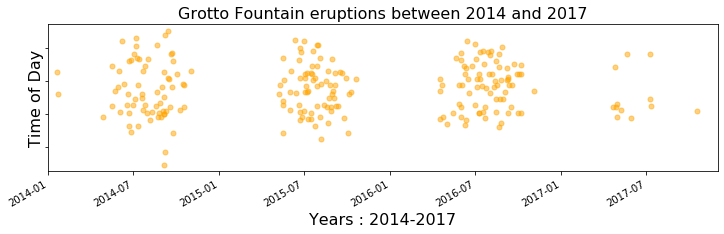

In [24]:
edadf = df.loc[df['geyser']=='Grotto Fountain']
print(edadf.shape)
edadf = edadf['2014':'2017']
print(edadf.shape)

edadf['time'] = [d.strftime("%H:%M:%S") for d in edadf['time']]
edadf['time'] = [ d[:-3] for d in edadf['time']]
edadf['time'] = [ d.replace(':','') for d in edadf['time']]
edadf['time'] = [ int(d) for d in edadf['time']]
#edadf.time.plot(linewidth=0.5)
ax = edadf.time.plot(marker='.', alpha=0.5, color='orange', linestyle='None', figsize=(12, 3), markersize=10)
ax.set_xlabel("Years : 2014-2017", fontsize=16)
ax.set_ylabel("Time of Day", fontsize=16)
ax.set_title("Grotto Fountain eruptions between 2014 and 2017", fontsize=16)
ax.set_xlim('2014-01','2017-12')
plt.tick_params(axis='y', labelleft=False)



This is clear when we plot the same graph for another geyser in the area called Grotto which shows a hard line on the dates from which data collection is started.

(11792, 5)
(3284, 5)


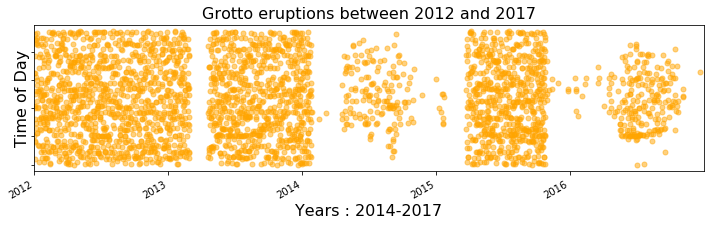

In [25]:
edadf = df.loc[df['geyser']=='Grotto']
print(edadf.shape)
edadf = edadf['2012':'2017']
print(edadf.shape)

edadf['time'] = [d.strftime("%H:%M:%S") for d in edadf['time']]
edadf['time'] = [ d[:-3] for d in edadf['time']]
edadf['time'] = [ d.replace(':','') for d in edadf['time']]
edadf['time'] = [ int(d) for d in edadf['time']]
#edadf.time.plot(linewidth=0.5)
ax = edadf.time.plot(marker='.', alpha=0.5, color='orange', linestyle='None', figsize=(12, 3), markersize=10)
ax.set_xlabel("Years : 2014-2017", fontsize=16)
ax.set_ylabel("Time of Day", fontsize=16)
ax.set_title("Grotto eruptions between 2012 and 2017", fontsize=16)
ax.set_xlim('2012','2017')
plt.tick_params(axis='y', labelleft=False)



End of Notebook - Check train_Model.ipynb next